# GOOGL stock 'Close' value prediction

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

## Importing single location NARR-gridMET data

In [44]:
# stock_name = 'GOOGL'
# df = get_stock_data(stock_name,0)
# df.tail()

df = pd.read_csv('/home/dp/Documents/FWP/NARR_gridMET/csv/Training/Continuous/df_NARR_gridMET_Kalmiopsis_all_years.csv', header='infer')
display('df head:', df.head(5))
display('df tail:', df.tail(5))

'df head:'

,time,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
0,1979-01-02,5715.97000,1.631845,-11.812575,102689.125,50.257525,84.694812,23.0
1,1979-01-03,5650.36625,8.283511,-4.332774,101987.375,3.994009,73.726234,25.0
2,1979-01-04,5596.66250,10.444422,-2.467009,101681.250,-18.707662,-4.352164,15.0
3,1979-01-05,5600.45250,2.961868,-6.659581,101705.625,106.575925,162.815328,26.0
4,1979-01-06,5585.27625,-0.860342,-5.186507,101381.375,40.390296,30.786914,28.0


'df tail:'

,time,H500,H500 Grad X,H500 Grad Y,PMSL,PMSL Grad X,PMSL Grad Y,ERC
1816,1983-12-27,5508.1800,-10.000355,-40.544150,101366.750,-53.391523,22.134313,0.0
1817,1983-12-28,5619.3700,-11.723684,-17.322113,102048.000,119.783963,102.634012,0.0
1818,1983-12-29,5695.6575,0.358575,-14.475804,101878.750,-21.613663,-87.943675,0.0
1819,1983-12-30,5641.4650,13.035607,-20.645963,101919.875,-21.588763,-118.073588,0.0
1820,1983-12-31,5610.7400,2.008021,-31.701650,102444.000,-71.758150,-15.401160,0.0


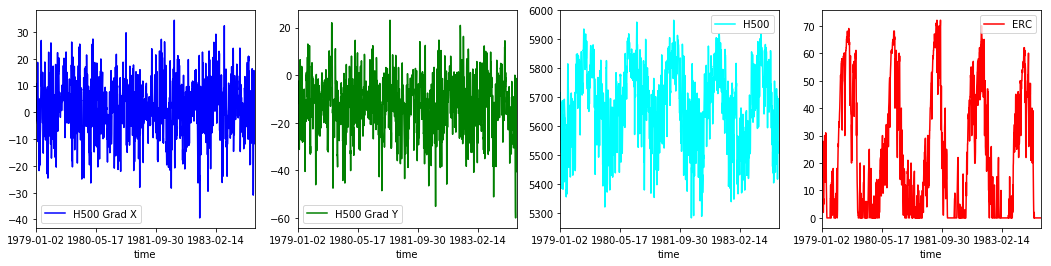

In [45]:
# Plotting ERC and H500 X gradient
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(18,4))
df.plot(x='time', y='H500 Grad X', ax=ax1, color='blue')
df.plot(x='time', y='H500 Grad Y', ax=ax2, color='green')
df.plot(x='time', y='H500', ax=ax3, color='cyan')
df.plot(x='time', y='ERC', ax=ax4, color='red')
plt.show()

'df to train on:'

,H500,PMSL,ERC
0,5715.97000,102689.125,23.0
1,5650.36625,101987.375,25.0
2,5596.66250,101681.250,15.0
3,5600.45250,101705.625,26.0
4,5585.27625,101381.375,28.0


'Scaled data:'

array([[0.63343041, 0.88619543, 0.31944444],
       [0.53718219, 0.7169507 , 0.34722222],
       [0.45839263, 0.64312093, 0.20833333],
       [0.46395299, 0.64899957, 0.36111111],
       [0.4416877 , 0.5707985 , 0.38888889],
       [0.44101282, 0.62551514, 0.19444444],
       [0.42792433, 0.59482559, 0.15277778],
       [0.3955176 , 0.64079962, 0.125     ],
       [0.5817733 , 0.66880609, 0.06944444],
       [0.50399789, 0.46178729, 0.02777778]])

'Scaled Open price:'

array([0.63343041, 0.53718219, 0.45839263, ..., 0.60362964, 0.52412303,
       0.47904594])

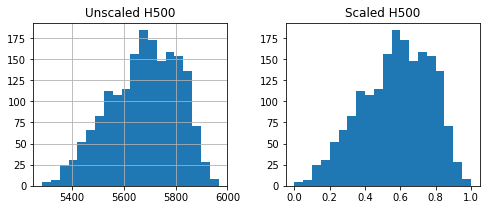

In [46]:
# Specify columns to train on
df = df.loc[:, ['H500','PMSL','ERC']]
display('df to train on:', df.head(5))

# Scaling:
scaler = preprocessing.MinMaxScaler()
data = df.values
data = scaler.fit_transform(data)
display('Scaled data:', data[:10])
display('Scaled Open price:', data[:, 0])

# Plotting hist of scaled data:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
df.hist('H500', bins=20, ax=ax1)
ax2.hist(data[:,0], bins=20)
ax1.set_title('Unscaled H500')
ax2.set_title('Scaled H500')
plt.show()

## Updated load_data function from lstm.py, configured to accept any amount of features.
## It is set to calculate the last feature as a result.

In [47]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]


## Building model functions

In [48]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16, activation="relu", kernel_initializer="uniform")) 
        model.add(Dense(1, activation="relu", kernel_initializer="uniform"))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

## Setting X and Y for training and testing

In [49]:
window = 14
X_train, y_train, X_test, y_test = load_data(df[::-1], window)
print("X_train", X_train.shape)
print('X_train[:3,:]:\n', X_train[:3,:])
print("y_train", y_train.shape)
print('y_train[:3]:\n', y_train[:3])
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (1625, 14, 3)
X_train[:3,:]:
 [[[0.63343041 0.88619543 0.31944444]
  [0.53718219 0.7169507  0.34722222]
  [0.45839263 0.64312093 0.20833333]
  [0.46395299 0.64899957 0.36111111]
  [0.4416877  0.5707985  0.38888889]
  [0.44101282 0.62551514 0.19444444]
  [0.42792433 0.59482559 0.15277778]
  [0.3955176  0.64079962 0.125     ]
  [0.5817733  0.66880609 0.06944444]
  [0.50399789 0.46178729 0.02777778]
  [0.32889042 0.59693587 0.05555556]
  [0.44624675 0.79693044 0.09722222]
  [0.26450426 0.41032652 0.06944444]
  [0.15005098 0.30456816 0.06944444]]

 [[0.53718219 0.7169507  0.34722222]
  [0.45839263 0.64312093 0.20833333]
  [0.46395299 0.64899957 0.36111111]
  [0.4416877  0.5707985  0.38888889]
  [0.44101282 0.62551514 0.19444444]
  [0.42792433 0.59482559 0.15277778]
  [0.3955176  0.64079962 0.125     ]
  [0.5817733  0.66880609 0.06944444]
  [0.50399789 0.46178729 0.02777778]
  [0.32889042 0.59693587 0.05555556]
  [0.44624675 0.79693044 0.09722222]
  [0.26450426 0.41032652 0.06944444

## Loading the model sequence structure

In [50]:
# model = build_model([3,lag,1])
model = build_model2([3,window,1])

## Executing the model & RMS/RMSE results

In [51]:
t0 = time.time()

model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1,
    verbose=0)

t1 = time.time() - t0
print('Fit time:', t1)

In [52]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.07 RMSE)
Test Score: 0.01 MSE (0.07 RMSE)


In [53]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

/home/dp/anaconda3/envs/fwp_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


## Predictions vs Real results

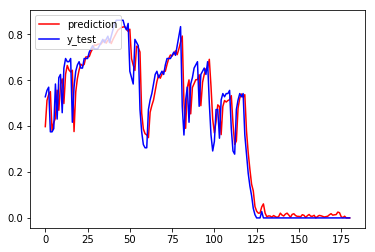

In [54]:
import matplotlib.pyplot as plt2

plt2.plot(p,color='red', label='prediction')
plt2.plot(y_test,color='blue', label='y_test')
plt2.legend(loc='upper left')
plt2.show()